# import

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from statistics import mean 

In [10]:
# create SparkSession
spark = SparkSession.builder.master("local[*]") \
                    .appName('SparkSNCF') \
                    .getOrCreate()

# extract SparkContext
sc = spark.sparkContext

print('Spark is ready with CPU usage :', sc.defaultParallelism)

Spark is ready with CPU usage : 8


# import data

In [11]:
table_prix = sc.textFile('./data/tarifs-tgv-par-od.csv')
table_prix

./data/tarifs-tgv-par-od.csv MapPartitionsRDD[33] at textFile at <unknown>:0

In [12]:
table_prix_head = table_prix.take(1)
table_prix_no_header = table_prix.filter(lambda row: row != table_prix_head[0])

In [13]:
new_table_prix = table_prix_no_header.map(lambda line: tuple(line.split(';')[0:4:3])) \
                                     .map(lambda x: tuple(x[0].split('-', 1) + [float(x[1])])) \
                                     .map(lambda x : (x[0].strip(), x[1].strip(), x[2]))
columns = ["origine","destination","prix_1"]
df = spark.createDataFrame(data=new_table_prix, schema = columns)

df.show()

+--------------------+--------------------+------+
|             origine|         destination|prix_1|
+--------------------+--------------------+------+
|               NIMES|        LILLE EUROPE| 184.0|
|MOUTIERS SALINS B...|             QUIMPER| 190.0|
|              LANDRY|             QUIMPER| 190.0|
|  TGV HAUTE PICARDIE|                AGDE| 188.0|
|  TGV HAUTE PICARDIE|                SETE| 188.0|
|  PARIS GARE DE LYON|              TOULON| 166.0|
|  PARIS GARE DE LYON|         MONTBELIARD| 119.0|
| LIMOGES BENEDICTINS|AEROPORT CDG 2 TG...| 111.0|
|         CHATEAUROUX|AEROPORT CDG 2 TG...|  86.0|
|CHAMBERY CHALLES ...|           MASSY TGV| 136.0|
|           MASSY TGV|AIX LES BAINS LE ...| 136.0|
|AEROPORT CDG 2 TG...|AIX LES BAINS LE ...| 136.0|
|          NICE VILLE|    CHALON SUR SAONE| 151.0|
|             BELFORT|MONTBELIARD TGV-L...|  53.0|
|MARSEILLE ST CHARLES|     LONS LE SAUNIER| 119.0|
|     BESANCON VIOTTE|        LILLE EUROPE| 155.0|
|      ANGERS ST LAUD|         

In [14]:
def itineraryPrice(station1, station2):
    station1, station2 = station1.strip().upper(), station2.strip().upper()
    tuple_prix = df.where(f"(origine = '{station1}' AND destination = '{station2}' OR origine = '{station2}' AND destination = '{station1}')").collect()
    if tuple_prix == []:
        return None
    elif sum([row[2] in ('', 'nan', None) for row in tuple_prix]) > 0:
        return None
    else:
        return mean([row[2] for row in tuple_prix])
print(itineraryPrice("nimes", "LILLE EUROPE"))
print(itineraryPrice("nimes", "PALITA"))
print(itineraryPrice("TOURS", "LILLE FLANDRES"))
print(itineraryPrice('CULOZ', 'LIBOURNE'))

184.0
None
134.0
None


In [15]:
df_gare_loc_sql = spark.read.option("delimiter", ";").option("header",True).csv("./data/referentiel-gares-voyageurs.csv")
df_gare_loc_sql.createOrReplaceTempView("sncf_tgv_loc")

from geopy.distance import geodesic
df_gare_loc = spark.sql("SELECT `Intitulé gare`, Latitude, Longitude FROM sncf_tgv_loc")
df_gare_loc_pd = df_gare_loc.toPandas()
df_gare_loc_pd.dropna(inplace=True)
pds = df_gare_loc_pd.apply(lambda x: (x[0], (float(x[1]), float(x[2]))), axis=1, result_type='expand')
pds.columns = ['gare', 'coordonne']
list_name_gare =  pds['gare']
list_name_gare

0                       Osséja
1       Font-Romeu-Odeillo-Via
2                       Planès
3                        Sauto
4                Thuès Carença
                 ...          
2862                La Barasse
2863                Rosa Parks
2864          Nice Pont Michel
2865             Irigny Yvours
2866            Le Bourget T11
Name: gare, Length: 2863, dtype: object

In [68]:
def coord_gps(gare):
    origan_location = locator.geocode(gare)
    try: 
        return (origan_location.latitude, origan_location.longitude)
    except:
        return (1,1)

def distance(gares):
    coord1 = coord_gps(gares[0])
    coord2 = coord_gps(gares[1])
    distance = geodesic(coord1, coord2)
    return distance

In [31]:
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="my_geocoder")
from geopy.distance import geodesic

In [65]:
origine_list = new_table_prix.map(lambda x: (x[0]))
destination_list = new_table_prix.map(lambda x: (x[1]))
set_origine = set(origine_list.collect())
set_destination = set(destination_list.collect())
final = set_origine.union(set_destination)
list_coordonne = [coord_gps(gare) for gare in final]
couple_gare_coor = tuple(zip(final, list_coordonne))
data_gare = pd.DataFrame(couple_gare_coor, columns = ['gare', 'coordonne'])
data_gare.set_index('gare', inplace=True)
data_gare.at['PARIS NORD', 'coordonne'] = (48.881399, 2.357438)

In [166]:
def distance(gares):
    coord1 = data_gare.loc[gares[0]].values[0]
    coord2 = data_gare.loc[gares[1]].values[0]
    if (1,1) in (coord1, coord2):
        return (gares[0],gares[1], gares[2], 0)
    distance = geodesic(coord1, coord2).miles
    if distance is None:
        return (gares[0],gares[1], gares[2], 42)
    return (gares[0],gares[1], gares[2], distance)


table_prix_distance  = new_table_prix.map(distance)
final_data = table_prix_distance.map(lambda x : ("-".join(x[0:2]), x[2], x[3]))
#pandas_df = final_data.select("*").toPandas()
dfFromRDD2 = spark.createDataFrame(final_data).toDF('trajet', "prix", "distance")
#df = spark.createDataFrame(data=final_data, schema=columns)

In [167]:
dfFromRDD1 = dfFromRDD2.dropna(subset=['distance'])
df = dfFromRDD1.toPandas().sort_values("distance")

<AxesSubplot:xlabel='distance', ylabel='prix'>

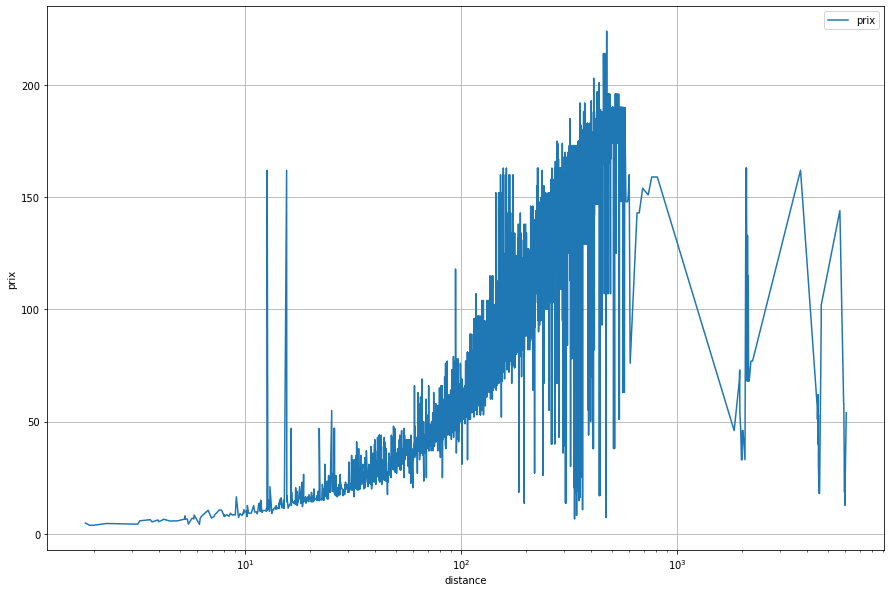

In [168]:
df.plot(x="distance",y="prix", figsize=(15, 10), grid=True, xlabel="distance", ylabel="prix", logx=True)

In [ ]:
#df.plot(x="trajet", y="prix", kind="barh")

In [147]:
dfFromRDD1['prix']

Column<b'prix'>